# Intro to simple text classification in PyTorch

This notebook demonstrates training a deep neural network to classify the sentiment (positive or negative) of a movie review.

It will take the following setps:

**Step 0** - Prepare texts  
**Step 1** - Load your dataset  
**Step 2** - Create an empty neural network model  
**Step 3** - Train the model  
**Step 4** - Test and evaluate the training results  


> Note: If the following codes give you an error like `No module named 'sklearn'` or `No module named 'matplotlib'`, it means you have not yet installed matplotlib or sklearn. To install it, open up a terminal/command window, activate your environment (e.g., `conda activate coding3`), and then type `conda install matplotlib` and `conda install scikit-learn`  
You may have to restart the kernel if the cell does not complete running after you install.

> Note that you will only ever have to do this once per environment (e.g., from now on, when you run a new notebook that imports from matplotlib using this same environment, it will also be able to use that library; no need to install again)

Before we start, let's config the device PyTorch is using

In [2]:
import torch

device = "cpu"

if torch.cuda.is_available():
    device = "cuda"

elif torch.backends.mps.is_available():
    device = "mps"

print(f'Using device: {device}')

Using device: mps


## **Step 0** - Prepare text  data

We're going to use a small set of 1000 movie reviews from IMDB. [The original dataset can be found here.](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?resource=download) 

Here's how to load in the dataset into the notebook:

In [3]:
import pandas as pd

In [4]:
# This assumes the IMDBsubset.csv file lives in a directory called "data" which lives in the same directory as this notebook.
# ***if you want to edit this notebook to use a different dataset, edit this to specify a different file:
df = pd.read_csv("data/IMDBsubset.csv")

Now we've got the data read in! We've used a special data type called a "data frame", using the Pandas library, to store this data. Pandas makes working with data pretty convenient.

Printing df will show you the data in a table-like format (specifically, it'll show you the first and last few rows of the table).

**Note that a sentiment of "1" means "positive" and "0" means "negative"**

In [5]:
pd.set_option('display.max_colwidth', None) 
# display.max_colwidth means: show me everything in the column, even if it's long!

df # it will display the first and last few examples

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",1
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",1
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",1
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, f

## **Step 1** - Load your dataset

#### **1.1** - Pre-process texts

Let's do something super simple to transform this into a dataset that we can send to a neural network. 

Similarly to the sentiment classification we discussed in lecture last week, we're going to represent each example (review) as a vector of word counts.

The CountVectorizer object from the 'sklearn' library allows us to make these word count vectors pretty easily. Once we do the counts, we'll store these in a new dataframe.

Transform a dataframe containing a column named `review`,  
such that each row becomes represented by a **set of word counts**, corresponding to the number of each term in the review


In [6]:
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
# The following codes perform word counting:

# remove numeric characters present in the text
def preprocess_text(text):
    return re.sub(r'\d+', '', text.lower())

# stop_words='english' removes very common english words that are unlikely to be useful (e.g. "and", "the")
# min_df=0.1 removes very rare words that are likely to be typos, uninformative, etc.
vectorizer = CountVectorizer(stop_words='english', preprocessor=preprocess_text, min_df=0.01)

#***Note that "df['review']" is used below because "review" is the name of the column containing our text in the dataframe
#If you apply this to your own data, you may probably need to change this column name!
matrix = vectorizer.fit_transform(df['review'])
    
#This line converts matrix into another dataframe, with column names corresponding to the word being counted
data = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names_out())

Take a look at the dataframe

In [8]:
num_wordcount = data.shape[1]
print(data) #prints data to screen
data.shape

     ability  able  absolutely  absurd  academy  accent  accents  accept  \
0          0     0           0       0        0       0        0       0   
1          0     0           0       0        0       0        0       0   
2          0     0           0       0        0       0        0       0   
3          0     0           0       0        0       0        0       0   
4          0     0           0       0        0       0        0       0   
..       ...   ...         ...     ...      ...     ...      ...     ...   
995        0     0           0       0        0       0        0       0   
996        0     0           0       0        0       0        0       0   
997        0     0           1       0        0       0        0       0   
998        0     0           0       0        0       0        0       0   
999        0     0           0       0        0       0        0       0   

     accident  account  ...  year  years  yes  york  young  younger  youth  \
0        

(1000, 1660)

We have 1000 rows and 1660 columns, this means that we have 1000 reviews, and there are 1660 unique words in all these reviews, the numbers in the table 

Note that you can examine this dataset, e.g. to look at the column of counts for the word "wonderful":

In [9]:
data["good"]

0      0
1      0
2      0
3      0
4      2
      ..
995    0
996    0
997    0
998    2
999    0
Name: good, Length: 1000, dtype: int64

My output says:
```
0      0
1      0
2      0
3      0
4      2
      ..
995    0
996    0
997    0
998    2
999    0
```

This means that the word "good" appears in the 4th review twice, appears in the 998th review twice, 

In [10]:
# or the word "hate":
data["hate"]

0      0
1      0
2      0
3      0
4      0
      ..
995    0
996    1
997    0
998    0
999    0
Name: hate, Length: 1000, dtype: int64

Let's create a mapping function that turn a line of text into wordcount

In [11]:
# Turns a text string into a dataframe example (***Note you'll need to change this from 'review' for your own dataset)
def createExample(myText):

    newExample = np.array([[myText]])
    tdf = pd.DataFrame(newExample, columns=["review"])
    matrix = vectorizer.transform(tdf['review'])
    newDf = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names_out())
    return newDf

In [12]:
#Here's a text about zombies
myText = "This movie is absolutely zombies zombies zombies"
t = createExample(myText)
print(t)

   ability  able  absolutely  absurd  academy  accent  accents  accept  \
0        0     0           1       0        0       0        0       0   

   accident  account  ...  year  years  yes  york  young  younger  youth  \
0         0        0  ...     0      0    0     0      0        0      0   

   zero  zombie  zombies  
0     0       0        3  

[1 rows x 1660 columns]


When we print the dataframe above, you see wordcount for "absolutely" is 1, wordcount for "zombies" is 3.

You might have noticed that the count for most words will be 0 for any particular text. Sometimes it's useful to look at just the nonzero word counts. Here's a quick function to do that for the output of our createExample function.

In [13]:
def getNonzeroCounts(myExample):
    counts = myExample.iloc[0]
    return(counts[counts != 0])

getNonzeroCounts(t)

absolutely    1
movie         1
zombies       3
Name: 0, dtype: int64

#### **1.2** - Create dataset loaders  

In order to load images during training, we're going to use something called "data loader".  
These data loaders loads images into batches according to the pre-processes pipeline we have defined previously.

We'll be using PyTorch's [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) to create a training data loader and a testing data loader.  


In [14]:
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

In [15]:
# how many texts are going to be put into the testing set, 
# e.g. 0.1 means 10% percent of texts
test_size = 0.1 

# how many texts will be used in one step of gradient descent, 
# this usually depend on your model / types of data / CPU or GPU's capability
batch_size = 16

There is a lot of discussion about how different batch sizes can affect training results, e.g. [here](https://www.cs.princeton.edu/~smalladi/blog/2024/01/22/SDEs-ScalingRules/). But as a rule of thumb: larger batch sizes can make your gradient less noisy and therefore safer for larger learning rates, but this is always subjected to different models and data, especially when training generative models. So a good way to decide batch sizes is to follow literatures or similar works.

In [16]:
# Remember: X is for input, y is for output
# The first argument of train_test_split is your training data (here, lives in "data" object you created using word counts)
# The second argument of train_test_split is your labels/targets for the training data. This lives in the "sentiment" column of the original dataframe df we loaded from the file.
# (***If you are using a different dataset, you'll need to change the name of this column to whatever it is in your dataset)
# The test_size argument specifies % of data going into test set: here, 20% of the data goes into test set and 80% goes into training set
X_train, X_test, y_train, y_test = train_test_split(data, df['sentiment'], test_size=test_size, random_state=1)

In [17]:
# create your datset
train_dataset = TensorDataset(torch.Tensor(X_train.values), torch.Tensor(y_train.values))
# create your dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True) 

# create your datset
test_dataset = TensorDataset(torch.Tensor(X_test.values), torch.Tensor(y_test.values)) 
# create your dataloader
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=True) 

In [18]:
print(f'{len(train_dataset)} training texts loaded')
print(f'{len(test_dataset)} testing texts loaded')


900 training texts loaded
100 testing texts loaded


#### **1.3** - Check our data
Now we have the `train_loader` and the `test_loader` objects,  
We can use them to load and visualise some of our data

In [19]:
data, labels = next(iter(train_loader))

print(f'data shape: {data.shape}')
print(f'labels shape: {labels.shape}')

data shape: torch.Size([16, 1660])
labels shape: torch.Size([16])


## **Step 2** - Load an empty neural network model   

We're going to skip over the details of how to setup a neural network model for now, they will be covered next week. If you want to have a sneak peek, feel free to check the `./src/model.py` file.  

For now, trust that the code makes a new neural network according to your dataset configurations.  
However, there're three important parameters:

 - `num_features` defines the number of unique word we have.
 - `num_classes` defines how many categories we are classifying  
 

In [20]:
from src.model import DenseNeuralNetwork

In [21]:
model = DenseNeuralNetwork(num_features = num_wordcount)
model.to(device)

DenseNeuralNetwork(
  (dense): ModuleList(
    (0): Linear(in_features=1660, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

## **Step 3** - Train the model

#### **3.1** - Define optimiser and loss function

First, let's define an optimizer and the type of error (loss) function:
 - we use the `adam` optimizer
 - we use the binary cross entropy `BCELoss` as our loss function 
 
This means: during the training process, the adam optimizer will try to minimise errors calculated by the binary cross entropy loss .

In [22]:
import torch

In [23]:
# binary cross entropy
loss_function = torch.nn.BCELoss()

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

#### **3.2** - Break and Recap

Up to this point, we have defined a lot of components for the model training.   
Let's recap what we have so far:
 - A training data loader `train_loader` and a testing data loader `test_loader` we defined in **Step 1**.
 - An empty neural network `model` we built in **Step 2**.
 - An optimizer `optimizer` and a loss function `loss_function` we just defined.

In the next step, we're going to program how they will coordinate during training. So...

#### **3.3** - Define training/ testing loop  

As an overview, each epoch has a training loop and a testing loop:   
In each training loop:
 - **Load**: The training data loader loads a batch of training data and their true class labels.
 - **Forward**: Forward pass the training data to our model, and get the predicted class labels.
 - **Loss**: Use the loss function to compares the predicted labels to the true labels, and compute the error.
 - **Optimise**: The optimizer slightly optimises our model based on the error computed by the loss function.

Once we finish a training loop, we do a testing loop. In a testing loop, we do exactly the same things as in a training loop, but we won't update our model. The testing results are only used to tell us how well the model is doing at the moment.

In each testing loop:
 - **Load**: The testing data loader loads a batch of testing data and their true class labels.
 - **Forward**: Forward pass the testing data to our model, and get the predicted class labels.
 - **Loss**: Use the loss function to compares the predicted labels to the true labels, and calculates the error.

In [24]:
# we can save the model regularly
save_every_n_epoch = 10

# total number of epochs we aim for
num_epochs = 10

# keep track of the losses, we can plot them in the end
train_losses = []
test_losses = []

print('Epoch 0')

for epoch in range(num_epochs): 
    
    
    #---- Training loop -----------------------------
    train_loss = 0.0
    model.train() 
    
    for i, data in enumerate(train_loader, 0):
        # Load: The training data loader loads a batch of training data and their true class labels.
        inputs, true_labels = data
        inputs = inputs.to(device)
        true_labels = true_labels.to(device)
        
        # Pass: Forward pass the training data to our model, and get the predicted classes.
        pred_labels = model(inputs)
        
        # Loss: The loss function compares the predicted classes to the true classes, and calculates the error.
        loss = loss_function(pred_labels, true_labels.unsqueeze(1))
        train_loss += loss.item()
        
        # Optimise: The optimizer slightly optimises our model based on the error.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        if i % 50 == 0:
            print(f'  -> Step {i + 1:04}, train loss: {loss.item():.4f}')
    
    
    #---- Testing loop -----------------------------
    test_loss = 0.0
    model.eval()
    
    with torch.inference_mode():
        for i, data in enumerate(test_loader, 0):
            # Load: The testing data loader loads a batch of testing data and their true class labels.
            inputs, true_labels = data
            inputs = inputs.to(device)
            true_labels = true_labels.to(device)
            
            # Pass: Forward pass the testing data to our model, and get the predicted classes.
            pred_labels = model(inputs)
            
            # Loss: The loss function compares the predicted classes to the true classes, and calculates the error.
            loss = loss_function(pred_labels, true_labels.unsqueeze(1))
            test_loss += loss.item()
    
    
    #---- Report some numbers -----------------------------
    
    # Calculate the cumulative losses in this epoch
    train_loss = train_loss / len(train_loader)
    test_loss = test_loss / len(test_loader)
    
    # Added cumulative losses to lists for later display
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    print(f'Epoch {epoch + 1}, train loss: {train_loss:.3f}, test loss: {test_loss:.3f}')
    
    # save our model every n epoch
    if (epoch+1) % save_every_n_epoch==0:
        torch.save(model.state_dict(), f'text_model_epoch{epoch:04}.pt')
        
# save the model at the end of the training process
torch.save(model.state_dict(), f'text_model_final.pt')

print("training finished, model saved to 'text_model_final.pt'")

Epoch 0
  -> Step 0001, train loss: 0.7118
  -> Step 0051, train loss: 0.6784
Epoch 1, train loss: 0.675, test loss: 0.649
  -> Step 0001, train loss: 0.6443
  -> Step 0051, train loss: 0.5844
Epoch 2, train loss: 0.602, test loss: 0.581
  -> Step 0001, train loss: 0.5518
  -> Step 0051, train loss: 0.4586
Epoch 3, train loss: 0.520, test loss: 0.540
  -> Step 0001, train loss: 0.4810
  -> Step 0051, train loss: 0.4921
Epoch 4, train loss: 0.434, test loss: 0.457
  -> Step 0001, train loss: 0.3336
  -> Step 0051, train loss: 0.3878
Epoch 5, train loss: 0.356, test loss: 0.428
  -> Step 0001, train loss: 0.2986
  -> Step 0051, train loss: 0.2238
Epoch 6, train loss: 0.289, test loss: 0.405
  -> Step 0001, train loss: 0.2066
  -> Step 0051, train loss: 0.2648
Epoch 7, train loss: 0.233, test loss: 0.360
  -> Step 0001, train loss: 0.1985
  -> Step 0051, train loss: 0.1978
Epoch 8, train loss: 0.187, test loss: 0.367
  -> Step 0001, train loss: 0.2328
  -> Step 0051, train loss: 0.1191
Ep

#### **3.4** - Plot Training Process

Plot how errors ("loss") change over time on the training set and the validation set

In [25]:
import matplotlib.pyplot as plt
import numpy as np

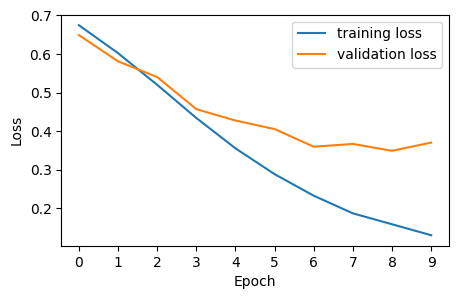

In [26]:
plt.figure(figsize=(5,3))
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label = 'validation loss')
plt.xticks(np.arange(len(train_losses)))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

## **Step 4** - Test and evaluate the training results   

#### **4.1** - Load model  
First, let's load our trained model. And set the model to 'evaluation' mode `.eval()` (check [torch.nn.Module.eval()](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.eval))

In [27]:
from src.model import DenseNeuralNetwork

In [28]:
# make sure the parameters are the same as when the model is created
eval_model = DenseNeuralNetwork(num_features = num_wordcount)

# load the saved model, make sure the path is correct
eval_model.load_state_dict(torch.load('text_model_final.pt'))

eval_model.to(device)
eval_model.eval() 

DenseNeuralNetwork(
  (dense): ModuleList(
    (0): Linear(in_features=1660, out_features=32, bias=True)
    (1): Sigmoid()
  )
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

#### **4.2** - Load some test data 

Data in the testing set has never been exposed to the model during the training process, so they are good to test if our model works fine on "new" data. Why? Because sometimes the model begins to **overfit** to the training set and is not able to "generalise" to data that are not in the training set.

In [29]:
# change this into something you made up:
test_text = 'A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, sense of realism to the entire piece.'


In [30]:
class_names = ["negative", "positive"]
test_data = createExample(test_text)

In [31]:
with torch.inference_mode():
    pred_labels = eval_model(torch.Tensor(test_data.values).to(device))

#### **4.3** - Interpret the output

`pred_labels` is our model's output. It's not a single class label, instead, it's a number indicating the probability of `label == 1`, i.e., the likelihood of the text is positive.

We can use `torch.round()` to round the output to 0 or 1

In [32]:
print(f'text: {test_text}\n')
print(f'probability: {pred_labels.item()}')

pred_labels = class_names[int(torch.round(pred_labels)[0][0])]
print(f'prediction: {pred_labels}')

text: A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, sense of realism to the entire piece.

probability: 0.6358627676963806
prediction: positive


#### **4.4** - Calculate accuracy  

Now we can run our model on the full testing set to calculate the accuracy of our model.  
In practice, we'll keep counting the correct predictions and check what percentage of the predictions are correct.

In [33]:
num_samples = 0
num_correct = 0

with torch.inference_mode():
    for i, data in enumerate(test_loader, 0):
        # Load: The testing data loader loads a batch of testing data and their true class labels.
        inputs, true_labels = data
        inputs = inputs.to(device)
        true_labels = true_labels.to(device)

        # Pass: Forward pass the testing data to our model, and get the predicted classes.
        pred_labels = eval_model(inputs)[:,0]
        pred_labels = torch.round(pred_labels)
        
        num_correct += pred_labels.size(0) - torch.count_nonzero(pred_labels - true_labels)
        num_samples += pred_labels.size(0) 
        
accuracy = num_correct / num_samples
print(f'correct samples: {num_correct}  \ntotal samples: {num_samples}  \nmodel accuracy: {accuracy:.3f}')

correct samples: 84  
total samples: 100  
model accuracy: 0.840
